In [1]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split


## Data Construction

We simulated a binary dataset consisting of a 1000 data points, the dataset follows a simple linear function $f(x)=mx + c$ where the x is generated randomly from a uniform distribution between $0$ and $1$ and a corresponding y value is calculated with added gaussian noise of mean $\mu=0$ and standard deviation $\sigma=0.25$. Since this dataset is simulated probabilistically by construction the X value of each data point is the probability of that point belonging to class 1.

In [2]:
def f(x):
    return 2*x + 1

x=np.random.uniform(0,1,10000)


x0 = []
y0 = []

x1 = []
y1 = []

Y1=np.zeros(len(x))

X1=np.zeros((len(x),2))


for i in range(len(x)):

    
    if np.random.random() < x[i]:
        x0.append(x[i])
        y0.append( f(x[i]) + np.random.normal(0,0.25)  )

        
    else:
        x1.append(x[i])
        y1.append( f(x[i]) + np.random.normal(0,0.25) ) 

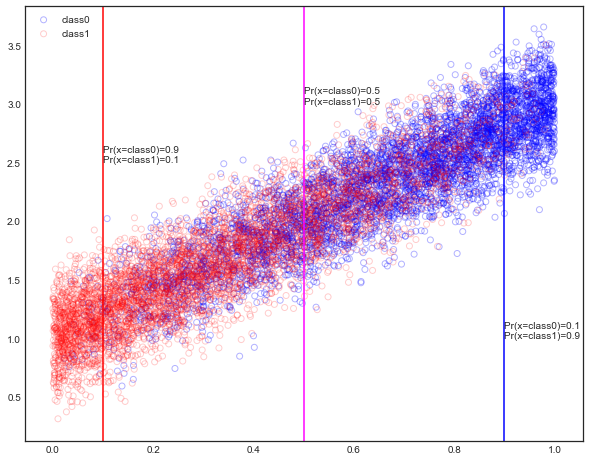

In [3]:
Y1=np.zeros(len(x0))
Y2=np.ones(len(x1))
Y=np.concatenate((Y1, Y2), axis=0)

x=np.concatenate((x0, x1), axis=0)
y=np.concatenate((y0, y1), axis=0)

X=np.stack((x, y), axis=-1)

X = np.asarray(X)
Y = np.asarray(Y)

#X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1)


scaler = StandardScaler()
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


plt.figure(figsize=(10,8))
plt.scatter(X[Y==0, 0], X[Y==0, 1], facecolors='none',edgecolors='b',label='class0',alpha=0.3)
plt.scatter(X[Y==1, 0], X[Y==1, 1], facecolors='none',edgecolors='r',label='class1',alpha=0.2)

plt.axvline(0.1,color='red')
plt.axvline(0.5,color='magenta')
plt.axvline(0.9,color='blue')
plt.text(0.1,2.5,s='Pr(x=class0)=0.9 ' + '\n' + 'Pr(x=class1)=0.1 ' )
plt.text(0.5,3,s='Pr(x=class0)=0.5 ' + '\n' + 'Pr(x=class1)=0.5 ' )
plt.text(0.9,1,s='Pr(x=class0)=0.1 ' + '\n' + 'Pr(x=class1)=0.9 ' )
plt.legend()
plt.show()


## Bayesian Neural Network Construction to apply variational inference on it by training on the whole training set as opposed to training on mini batches which will be discussed and observed later


A neural network is quite simple. The basic unit is a perceptron which is nothing more than logistic regression. We use many of these in parallel and then stack them up to get hidden layers. 

We now initialize random weights without biasses between each layer. These normal priors help us regulate the weights which rids us ofof of the need to add a bias constant $b$ to our weights.

Between the layers we will use a $tanh$ activatiopn function and use a $sigmoid$ function which will squeeze the output between zero and one

Network architecture :
- input layer with 2 neurons
- 2 hidden layers with 5 neurons (tanh)
- 1 output layer (sigmoid)

<img src="architecture.png">


We look to observe the reliability curve of the Bayesian neural network

In [4]:

def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network



# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)



In [5]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

from pymc3 import Normal,Metropolis, sample,find_MAP

In [6]:
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

def reliability_curve(y_true, y_score, bins=10, normalize=False):
    """Compute reliability curve

    Reliability curves allow checking if the predicted probabilities of a
    binary classifier are well calibrated. This function returns two arrays
    which encode a mapping from predicted probability to empirical probability.
    For this, the predicted probabilities are partitioned into equally sized
    bins and the mean predicted probability and the mean empirical probabilties
    in the bins are computed. For perfectly calibrated predictions, both
    quantities whould be approximately equal (for sufficiently many test
    samples).

    Note: this implementation is restricted to binary classification.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        True binary labels (0 or 1).

    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive
        class or confidence values. If normalize is False, y_score must be in
        the interval [0, 1]

    bins : int, optional, default=10
        The number of bins into which the y_scores are partitioned.
        Note: n_samples should be considerably larger than bins such that
              there is sufficient data in each bin to get a reliable estimate
              of the reliability

    normalize : bool, optional, default=False
        Whether y_score needs to be normalized into the bin [0, 1]. If True,
        the smallest value in y_score is mapped onto 0 and the largest one
        onto 1.


    Returns
    -------
    y_score_bin_mean : array, shape = [bins]
        The mean predicted y_score in the respective bins.

    empirical_prob_pos : array, shape = [bins]
        The empirical probability (frequency) of the positive class (+1) in the
        respective bins.


    References
    ----------
    .. [1] `Predicting Good Probabilities with Supervised Learning
            <http://machinelearning.wustl.edu/mlpapers/paper_files/icml2005_Niculescu-MizilC05.pdf>`_

    """
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

## We now run the MCMC sampler on the whole dataset 

By using pyMC3 packaged MCMC that uses metropolis Hastings algorithm to navigatte the sample space to produce the posterior distribution of the weights


In [7]:
%%time
'''with neural_network:
    inference = pm.NUTS() # instead of mcmc or NUTS() I use automated differential variational inference seems to be 
                            #faster than the other packaged sampling methods
    approx = pm.fit(n=40000, method=inference) # we train on the whole training set but it is better to train on mini batches
    trace = approx.sample(draws=5000) # here we draw samples from the posterior distribution , we use this for trace plots and histogrms

'''
with neural_network:
    start = find_MAP()
    step = Metropolis()
    trace = sample(10000, step, start=start)



logp = -4,541.4, ||grad|| = 0.2333: 100%|██████████| 1193/1193 [00:18<00:00, 64.12it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
100%|██████████| 10500/10500 [08:00<00:00, 21.85it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 29.2 s, sys: 1.41 s, total: 30.6 s
Wall time: 8min 49s


# Trace plot of our weights samples from our MCMC 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e78871710>,
      dtype=object)

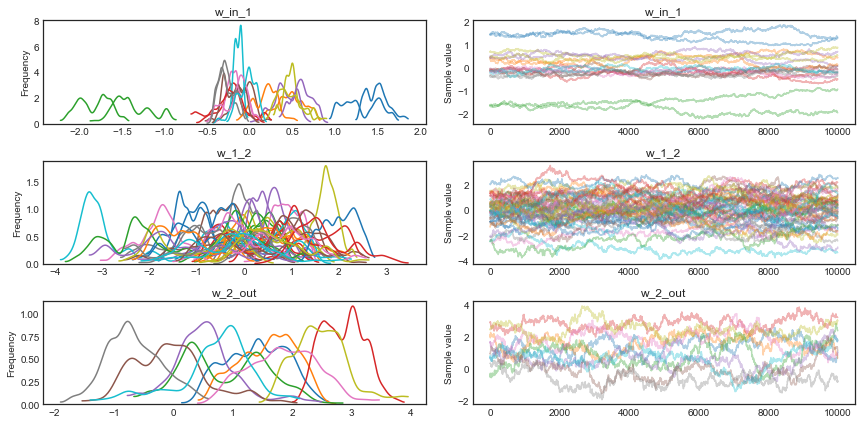

In [8]:
pm.traceplot(trace)

# We follow with a reliability plot of our Bayesian Neural Network

In [26]:
'''plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');'''

"plt.plot(-inference.hist)\nplt.ylabel('ELBO')\nplt.xlabel('iteration');"

In [17]:

bins=25

reliability_scores = {}
y_score = {}

ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=250, progressbar=False)
    

pred = ppc['out'].mean(axis=0) > 0.5

pred_binary=pred.astype(int)


y_score['BNN'] = ppc['out'].mean(axis=0)
reliability_scores['BNN']=\
reliability_curve(Y_test , y_score['BNN'], bins=bins , normalize=False)

	Accuracy = 75.1%
	Precision: 0.749
	Recall: 0.744
	F1: 0.747



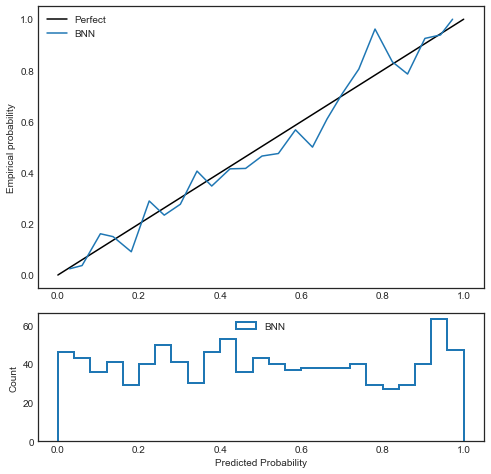

In [18]:
plt.figure(0, figsize=(8, 8))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect") 
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend(loc='upper center', ncol=2)


print('\tAccuracy = {}%'.format((Y_test == pred).mean() * 100))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred_binary))
print("\tRecall: %1.3f" % recall_score(Y_test, pred_binary))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred_binary))

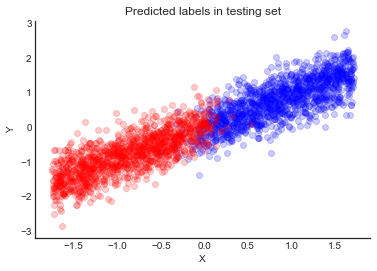

In [25]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b',alpha=0.2)
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r',alpha=0.2)
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

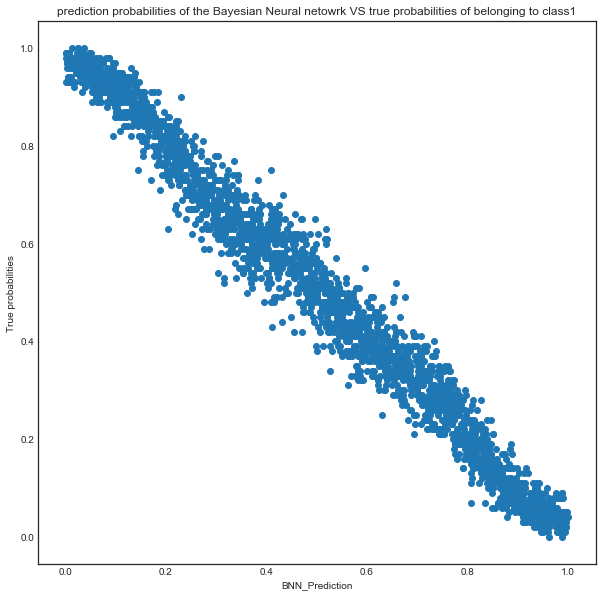

In [30]:

pred_prob=ppc['out'].mean(axis=0)
X_true=scaler.inverse_transform(X_test, copy=None)

plt.figure(figsize=(10,10))
plt.title('prediction probabilities of the Bayesian Neural netowrk VS true probabilities of belonging to class1')
plt.scatter(X_true[:,0],pred_prob)
plt.xlabel('BNN_Prediction')
plt.ylabel('True probabilities')
plt.show()

In [31]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)



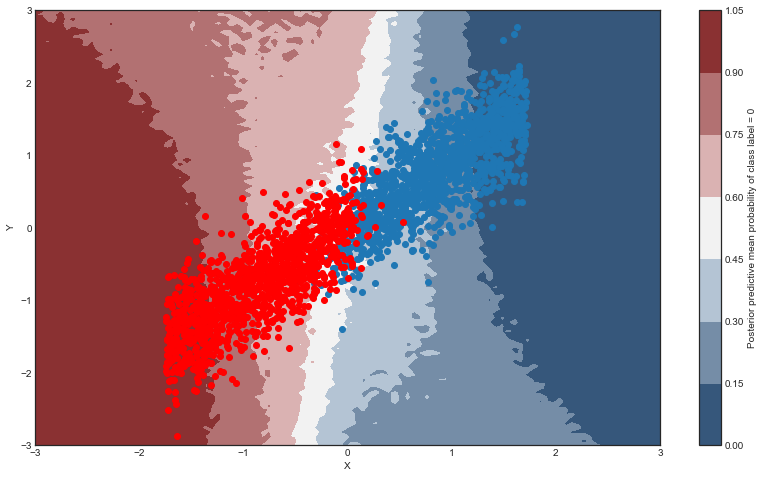

In [32]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

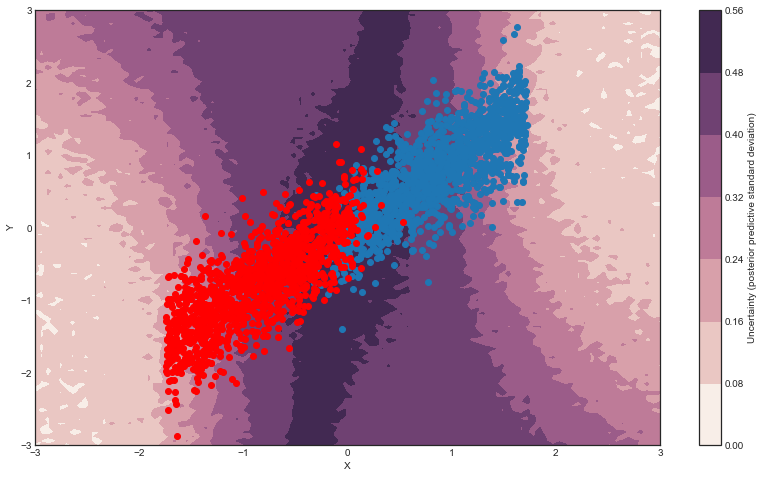

In [33]:


cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');



# - From here on is my own exploration and mini spirals



## Mini-batch ADVI - instead of training or fitting on the entire training set we shall prep the data so that we train the on mini batches proves to improve and be much faster

In [52]:
minibatch_x = pm.Minibatch(X_train, batch_size=32)
minibatch_y = pm.Minibatch(Y_train, batch_size=32)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference= pm.ADVI()
    approx_minib = pm.fit(40000, method=inference)

Average Loss = 3,962.7: 100%|██████████| 40000/40000 [00:25<00:00, 1589.35it/s]
Finished [100%]: Average Loss = 3,963.6


In [66]:
trace_minib = approx_minib.sample(draws=5000)
bins=25

reliability_scores = {}
y_score = {}

ann_input.set_value(X_test)
ann_output.set_value(Y_test)


with neural_network:
    ppc_minib = pm.sample_ppc(trace_minib, samples=500, progressbar=False)

pred = ppc_minib['out'].mean(axis=0) > 0.5
pred_binary=pred.astype(int)

y_score['BNN'] = ppc_minib['out'].mean(axis=0)
reliability_scores['BNN']=\
reliability_curve(Y_test , y_score['BNN'], bins=bins , normalize=False)

	Accuracy = 0.7704%
	Precision: 0.764
	Recall: 0.775
	F1: 0.770



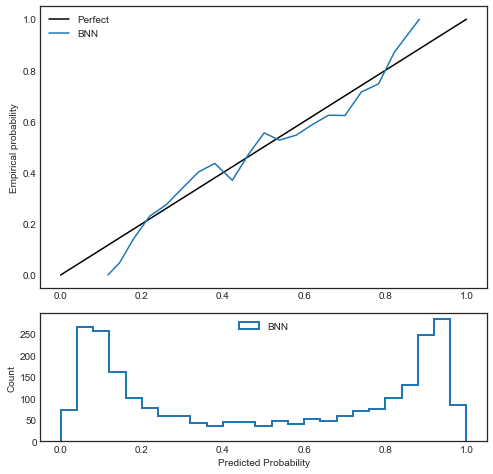

In [67]:
plt.figure(0, figsize=(8, 8))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect") 
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend(loc='upper center', ncol=2)


print('\tAccuracy = {}%'.format((Y_test == pred).mean() ))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred_binary))
print("\tRecall: %1.3f" % recall_score(Y_test, pred_binary))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred_binary))

## Now we make the plot where we compare our x vaules which by construction is our real probabilities of any point belonging to class 1 to the predicted probabilities

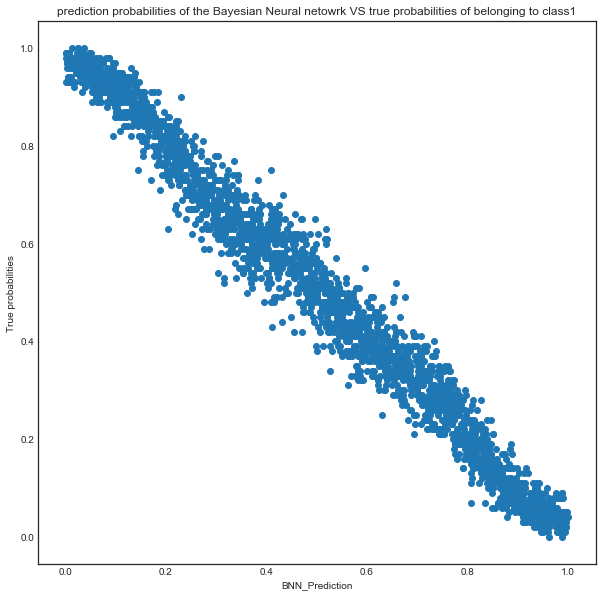

In [29]:

pred_prob=ppc['out'].mean(axis=0)
X_true=scaler.inverse_transform(X_test, copy=None)

plt.figure(figsize=(10,10))
plt.title('prediction probabilities of the Bayesian Neural netowrk VS true probabilities of belonging to class1')
plt.scatter(X_true[:,0],pred_prob)
plt.xlabel('BNN_Prediction')
plt.ylabel('True probabilities')
plt.show()

In [19]:


grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)



In [20]:


ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)



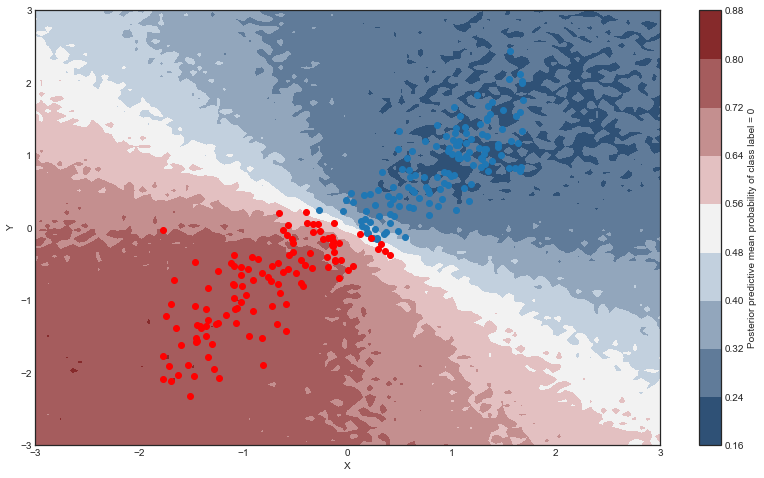

In [21]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

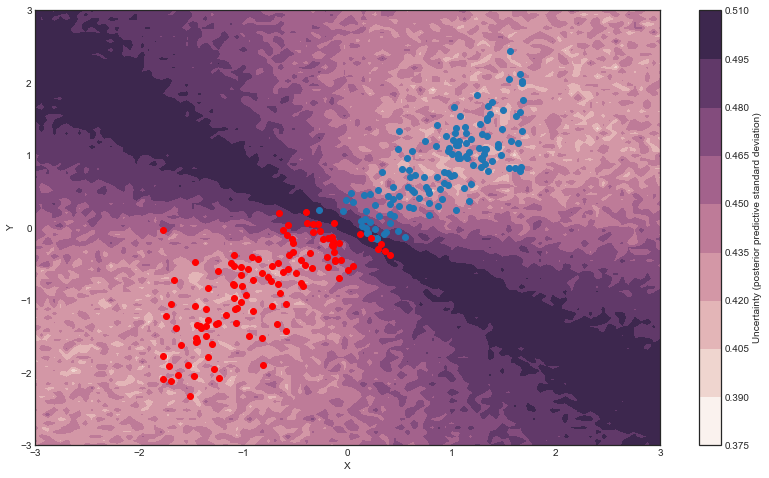

In [22]:


cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

